# Three machine learning models for predicting stroke
Code is from [here](https://www.kaggle.com/code/joshuaswords/predicting-a-stroke-shap-lime-explainer-eli5).

##Installations

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.2 MB/s eta 0:00:00


##Imports

In [3]:
import numpy as np 
import pandas as pd 
import shap
import pickle

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##Load dataset

In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


##Deal with missing values

In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [7]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


## Model preparation

In [8]:
# Encoding categorical values
df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

# Our data is biased, we can fix this with SMOTE
oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [9]:
print(X_train_resh)
print(y_train_resh)

print('Mean age', X_train_resh['age'].mean())
print('Std age', X_train_resh['age'].std())

print('Mean avg_glucose_level', X_train_resh['avg_glucose_level'].mean())
print('Std avg_glucose_level', X_train_resh['avg_glucose_level'].std())

print('Mean bmi', X_train_resh['bmi'].mean())
print('Std bmi', X_train_resh['bmi'].std())

      gender        age  hypertension  heart_disease  work_type  \
0          1  71.000000             0              0          0   
1          0  45.000000             0              0          0   
2          1  43.000000             0              0          2   
3          1  52.000000             1              0          1   
4          1  38.000000             0              0          0   
...      ...        ...           ...            ...        ...   
2909       0  56.071631             0              0          0   
2910       0  76.209224             0              0          0   
2911       0  73.005426             0              0          0   
2912       0  70.002244             0              0          0   
2913       0  63.168233             0              0          0   

      avg_glucose_level        bmi  
0            240.810000  27.400000  
1             99.910000  30.900000  
2             70.080000  26.600000  
3            233.290000  48.900000  
4         

## Models

In [10]:
# Scale our data in pipeline, then split
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(probability=True, random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])

rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('SVM mean :',cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.9387426109864275
SVM mean : 0.8780504918285896
Logistic Regression mean : 0.8366727329105945


In [11]:
rf_pipeline.fit(X_train_resh,y_train_resh)
svm_pipeline.fit(X_train_resh,y_train_resh)
logreg_pipeline.fit(X_train_resh,y_train_resh)

rf_pred = rf_pipeline.predict(X_test)
svm_pred = svm_pipeline.predict(X_test)
logreg_pred = logreg_pipeline.predict(X_test)

rf_cm = confusion_matrix(y_test,rf_pred )
svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm = confusion_matrix(y_test,logreg_pred )

rf_f1 = f1_score(y_test,rf_pred)
svm_f1 = f1_score(y_test,svm_pred)
logreg_f1 = f1_score(y_test,logreg_pred)

print('Mean f1 scores:')

print('RF mean :',rf_f1)
print('SVM mean :',svm_f1)
print('LR mean :',logreg_f1)

Mean f1 scores:
RF mean : 0.1670061099796334
SVM mean : 0.15816857440166496
LR mean : 0.1931818181818182


In [12]:
print("Report Random Forest:\n", classification_report(y_test,rf_pred))
print("Report SVM:\n", classification_report(y_test,svm_pred))
print("Report Logistic Regression:\n", classification_report(y_test,logreg_pred))

Report Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      3404
           1       0.13      0.24      0.17       173

    accuracy                           0.89      3577
   macro avg       0.54      0.58      0.55      3577
weighted avg       0.92      0.89      0.90      3577

Report SVM:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      3404
           1       0.10      0.44      0.16       173

    accuracy                           0.77      3577
   macro avg       0.53      0.62      0.51      3577
weighted avg       0.92      0.77      0.83      3577

Report Logistic Regression:
               precision    recall  f1-score   support

           0       0.97      0.77      0.86      3404
           1       0.12      0.59      0.19       173

    accuracy                           0.76      3577
   macro avg       0.54      0.68      0.53      3577
weighted 

##Hyperparameter optimization Random Forest

In [13]:
n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)
grid.fit(X_train_resh,y_train_resh)

print(grid.best_params_)

{'bootstrap': False, 'max_features': 2, 'n_estimators': 128}


In [14]:
# Let's use those params of the other notebook now
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(max_features=3,n_estimators=128,bootstrap=False))])
rf_pipeline.fit(X_train_resh,y_train_resh)
rfc_tuned_pred = rf_pipeline.predict(X_test)

print(classification_report(y_test,rfc_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3404
           1       0.13      0.21      0.16       173

    accuracy                           0.89      3577
   macro avg       0.55      0.57      0.55      3577
weighted avg       0.92      0.89      0.91      3577



##Hyperparameter optimization Logistic Regression

In [15]:
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 

log_param_grid = {'penalty': penalty, 
                  'C': C}
logreg = LogisticRegression()
grid = GridSearchCV(logreg,log_param_grid)

grid.fit(X_train_resh,y_train_resh)

print(grid.best_params_)

{'C': 10, 'penalty': 'l2'}


In [16]:
# Let's use those params of the other notebook now
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))])
logreg_pipeline.fit(X_train_resh,y_train_resh)
logreg_tuned_pred   = logreg_pipeline.predict(X_test)

print(classification_report(y_test,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      3404
           1       0.12      0.60      0.19       173

    accuracy                           0.76      3577
   macro avg       0.54      0.68      0.53      3577
weighted avg       0.93      0.76      0.83      3577



##Hyperparameter optimization SVM

In [17]:
# defining parameter range 
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
             'kernel': ['rbf']} 
svm = SVC(probability=True, random_state=42)
grid = GridSearchCV(svm,svm_param_grid)

grid.fit(X_train_resh,y_train_resh)
print(grid.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [18]:
# Let's use those params of the other notebook now
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(probability=True, C=1000,gamma=0.01,kernel='rbf',random_state=42))])
svm_pipeline.fit(X_train_resh,y_train_resh)
svm_tuned_pred  = svm_pipeline.predict(X_test)

print(classification_report(y_test,svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.78      0.87      3404
           1       0.09      0.41      0.15       173

    accuracy                           0.77      3577
   macro avg       0.53      0.60      0.51      3577
weighted avg       0.92      0.77      0.83      3577



## Shap values & feature importances

In [19]:
# Training data in df
X_train_shap = pd.DataFrame(X_train_resh, columns= X.columns)
# Names of the features
feature_names = X_train_shap.columns

### Logistic Regression

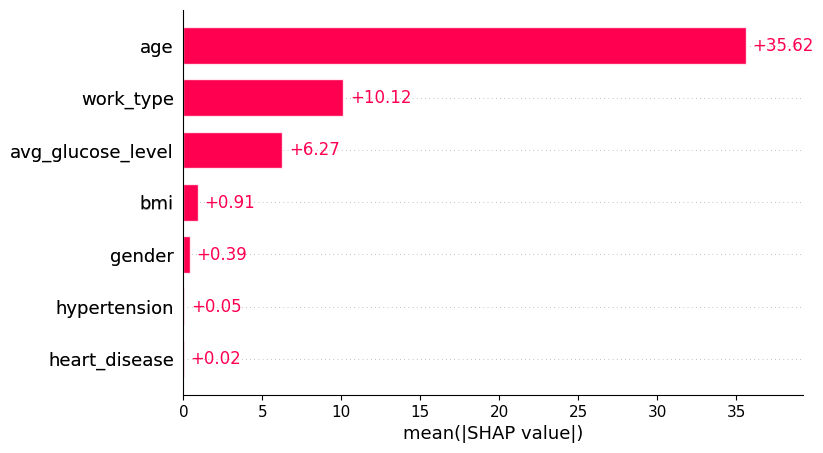

In [20]:
expl_lr_stroke = shap.Explainer(logreg_pipeline[-1], X_train_shap)
shap_val_lr_stroke = expl_lr_stroke(X_train_shap)
shap.plots.bar(shap_val_lr_stroke)
# shap.summary_plot(shap_val_lr_stroke, plot_type='bar')

In [21]:
pickle.dump(expl_lr_stroke,open("expl_lr_stroke.pkl","wb"))

In [22]:
pickle.dump(shap_val_lr_stroke,open("shap_val_lr_stroke.pkl","wb"))

### Random Forest

[0.01252867 0.01829691 0.05911897 0.07490406 0.18118264 0.20213569
 0.45183305]


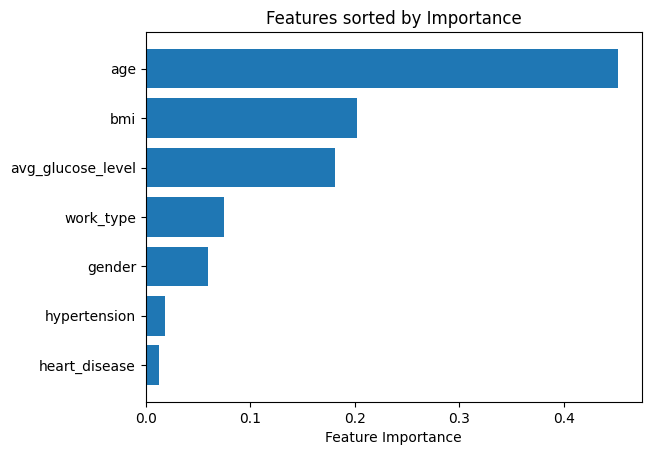

In [23]:
# Calculate the Importance of the features
feature_importance_rf = np.zeros(len(feature_names))
feature_importance_rf = np.add(feature_importance_rf, rf_pipeline[-1].feature_importances_)

# Sort the features on Importance
index_sorted_rf = feature_importance_rf.argsort()
print(feature_importance_rf[index_sorted_rf])

# Plot the Importance of the features
plt.barh(feature_names[index_sorted_rf], feature_importance_rf[index_sorted_rf])
plt.xlabel("Feature Importance")
plt.title("Features sorted by Importance")
plt.show()

### SVM

In [24]:
# not given

## Get a prediction

In [25]:
input_df = pd.DataFrame(
    {
        "gender": [0],
        "age": [0],
        "hypertension": [0],
        "heart_disease": [0],
        "work_type": [0],
        "avg_glucose_level": [0],
        "bmi": [0],
    }
)

In [28]:
rf_pipeline.predict_proba(input_df)

array([[1., 0.]])

In [33]:
logreg_pipeline.predict_proba(input_df)

array([[0.99653276, 0.00346724]])

In [32]:
svm_pipeline.predict_proba(input_df)

array([[9.9999990e-01, 1.0000001e-07]])

##Download models

In [ ]:
pickle.dump(rf_pipeline,open("rf_stroke.pkl","wb"))

In [34]:
pickle.dump(logreg_pipeline,open("lr_stroke.pkl","wb"))

In [ ]:
pickle.dump(svm_pipeline,open("svm_stroke.pkl","wb"))